In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from torch.utils.data import DataLoader
from dataset.dataloader import CINE2DT
from model.model_pytorch import CRNN_MRI
# from utils import multicoil2single, compressed_sensing as cs,IFFT2c
from utils import multicoil2single, compressed_sensing as cs
from utils.dnn_io import to_tensor_format, from_tensor_format
from utils.fastmriBaseUtils import FFT2c,IFFT2c
from trainer_dcrnn_test import prep_input
from torch.autograd import Variable
import os 
from PIL import Image
# import scipy.io as sio
from scipy.io import loadmat
import scipy.io as scio
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '3'  # ÊåáÂÆö‰ΩøÁî® GPU 1 Âíå GPU 4
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

## Â∞Ükgin_baseÁîüÊàêÁöÑ.npyËΩ¨Êç¢‰∏∫.matÊ†ºÂºè  ËØªÂèñ.matÊ†ºÂºèÊñá‰ª∂Âπ∂ÊòæÁ§∫

In [31]:
import scipy.io as scio
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_mat(fn_im_path):
    """‰∏ì‰∏öÂåªÂ≠¶ÂΩ±ÂÉèÂä†ËΩΩÂáΩÊï∞"""
    try:
        # Â∞ùËØïÁî®scipyÂä†ËΩΩ‰º†ÁªüÊ†ºÂºè
        f = scio.loadmat(fn_im_path)
        data_type = 'scipy_dict'
    except Exception:
        try:
            # Â∞ùËØïÂä†ËΩΩHDF5Ê†ºÂºè
            f = h5py.File(fn_im_path, 'r')
            data_type = 'hdf5'
        except IOError as e:
            raise IOError(f"Êñá‰ª∂ {fn_im_path} Êó†Ê≥ïËØªÂèñÔºåËØ∑Ê£ÄÊü•Êñá‰ª∂ÂÆåÊï¥ÊÄß„ÄÇÈîôËØØËØ¶ÊÉÖÔºö{str(e)}")
    
    # Áªü‰∏ÄÊï∞ÊçÆÊé•Âè£
    return {'data': f, 'type': data_type}

def display_medical_image(mat_path, var_name='image', slice_idx=None):
    """ÂåªÂ≠¶ÂΩ±ÂÉèÂèØËßÜÂåñÂáΩÊï∞"""
    # Âä†ËΩΩÊï∞ÊçÆ
    loader = load_mat(mat_path)
    
    # Ëß£ÊûêÊï∞ÊçÆÁªìÊûÑ
    if loader['type'] == 'scipy_dict':
        # Â§ÑÁêÜ‰º†ÁªüMATÊ†ºÂºè
        data_dict = loader['data']
        if var_name not in data_dict:
            raise KeyError(f"ÂèòÈáè {var_name} ‰∏çÂ≠òÂú®ÔºåÂèØÁî®ÂèòÈáèÔºö{list(data_dict.keys())}")
        image = data_dict[var_name]
    else:
        # Â§ÑÁêÜHDF5Ê†ºÂºè
        h5_file = loader['data']
        if var_name not in h5_file:
            raise KeyError(f"ÂèòÈáè {var_name} ‰∏çÂ≠òÂú®ÔºåÂèØÁî®ÂèòÈáèÔºö{list(h5_file.keys())}")
        image = np.array(h5_file[var_name])
    #image-shape: (192, 192, 18, 118)--ÁîüÊàêÁöÑkgin_base_1209_r8_recon.mat
    print('image-shape:',image.shape) #image-shape: (118, 18, 192, 192)
    # Êï∞ÊçÆÁª¥Â∫¶È™åËØÅ
    if image.ndim not in [2, 3, 4]:
        raise ValueError(f"‰∏çÊîØÊåÅÁöÑÁª¥Â∫¶ {image.shape}Ôºå‰ªÖÊîØÊåÅ2D/3D/4DÂåªÂ≠¶ÂΩ±ÂÉè")
    
    # Ëá™Âä®ÈÄâÊã©ÊòæÁ§∫ÂàáÁâá
    if image.ndim >= 3:
        if slice_idx is None:
            # Âèñ‰∏≠Èó¥Â±Ç
            slice_idx = image.shape[-1] // 2
        # image = image[..., slice_idx]
        # image = image[slice_idx,0,:,:]
        image = image[:,:,0,80]
    
    # ËΩ¨ÁΩÆÁª¥Â∫¶ÈÄÇÈÖçÊòæÁ§∫ (MATLABÁöÑÂàó‰ºòÂÖà -> PythonÁöÑË°å‰ºòÂÖà)
    image = np.transpose(image) if image.ndim == 2 else image
    print('image-shape-2:',image.shape) #image-shape-2: (192, 192)
    # ÂåªÂ≠¶ÂΩ±ÂÉèÊ†áÂáÜÂåñ
    vmin, vmax = np.percentile(image, [1, 99])
    image_display = np.clip((image - vmin) / (vmax - vmin), 0, 1)
    
    # ÂèØËßÜÂåñ
    plt.figure(figsize=(6, 6))
    plt.imshow(image_display, cmap='gray', vmin=0, vmax=1)
    plt.title(Path(mat_path).name)
    plt.axis('off')
    plt.colorbar(label='‰ø°Âè∑Âº∫Â∫¶ (a.u.)')
    plt.show()
    
    data_t_3_np = np.abs(image)  # ÂèñÊ®°
    # ÊòæÁ§∫ÂõæÂÉèÂüüÁöÑÊï∞ÊçÆ
    plt.figure(figsize=(6, 6))
    plt.imshow(data_t_3_np, cmap='gray')  # ‰ΩøÁî®ÁÅ∞Â∫¶È¢úËâ≤Êò†Â∞Ñ
    plt.title("data_t_3_np  (Á¨¨ 0 Â∏ß)")
    plt.axis('off')
    plt.show()

image-shape: (192, 192, 18, 118)
image-shape-2: (192, 192)


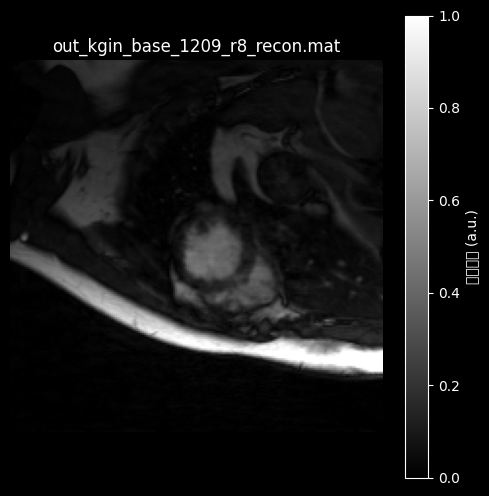

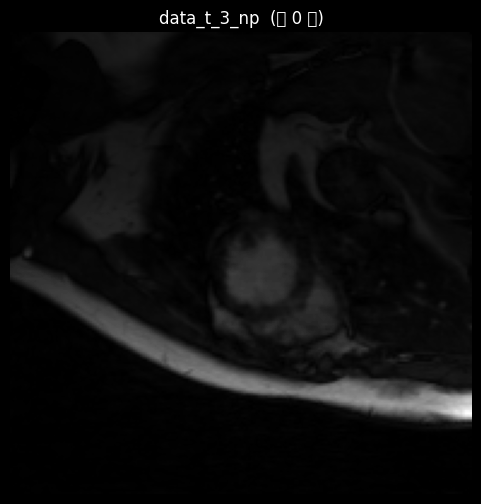

In [32]:
# ‰ΩøÁî®Á§∫‰æã
if __name__ == "__main__":
    # mat_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10_image.mat"
    # mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_kgin_base_1209_r8_image.mat'
    mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/converted_images/out_kgin_base_1209_r8_recon.mat'
    
    try:
        # Ëá™Âä®Ê£ÄÊµãÂèòÈáèÂêç
        test_data = scio.loadmat(mat_path)
        candidate_vars = [k for k in test_data.keys() if not k.startswith('__')]
        var_name = candidate_vars[0] if candidate_vars else 'image'
        
        # ÊòæÁ§∫ÂõæÂÉè
        display_medical_image(mat_path, var_name=var_name)
        
    except Exception as e:
        print(f"ÈîôËØØÂèëÁîüÔºö{str(e)}")
        print("Âª∫ËÆÆÊéíÊü•Ê≠•È™§Ôºö")
        print("1. Ê£ÄÊü•Êñá‰ª∂Ë∑ØÂæÑÊòØÂê¶Ê≠£Á°Æ")
        print("2. ‰ΩøÁî®h5pyÊü•ÁúãÊñá‰ª∂ÁªìÊûÑÔºö")
        print(f"   with h5py.File('{mat_path}', 'r') as f: print(f.keys())")
        print("3. È™åËØÅÊï∞ÊçÆÊòØÂê¶‰∏∫ÊµÆÁÇπÂûãÊï∞ÁªÑ")

## ‰ª•ÂõæÁâáÂΩ¢ÂºèÊòæÁ§∫dccnn ls

(118, 192, 192, 18) complex64


/data0/zhiyong/software/Anaconda3_2024/envs/k_gin_zzy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 31532 (\N{CJK UNIFIED IDEOGRAPH-7B2C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data0/zhiyong/software/Anaconda3_2024/envs/k_gin_zzy/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24103 (\N{CJK UNIFIED IDEOGRAPH-5E27}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


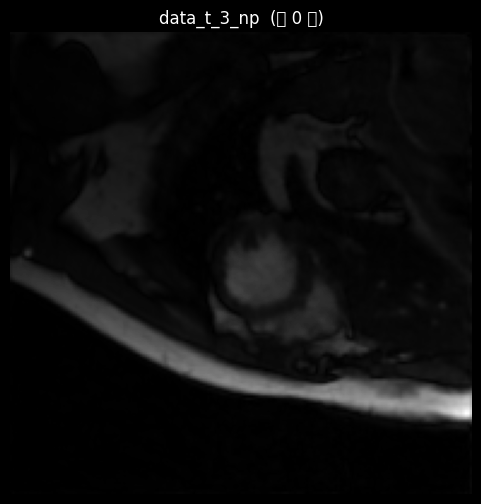

In [15]:
##ÊòæÁ§∫dccnn ls
file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_8_merge.npy'
data = np.load(file_path)
print(data.shape,data.dtype) #(118, 192, 192, 18) complex64

data_t_3_np = np.abs(data[80,:,:,0])  # ÂèñÊ®°
# ÊòæÁ§∫ÂõæÂÉèÂüüÁöÑÊï∞ÊçÆ
plt.figure(figsize=(6, 6))
plt.imshow(data_t_3_np, cmap='gray')  # ‰ΩøÁî®ÁÅ∞Â∫¶È¢úËâ≤Êò†Â∞Ñ
plt.title("data_t_3_np  (Á¨¨ 0 Â∏ß)")
plt.axis('off')
plt.show()


## ‰øùÂ≠òÂàùÂßãÁöÑCMRÊï∞ÊçÆ‰∏∫labelÂõæÁâá

In [ ]:
def load_mat(fn_im_path):
    try:
        f = scio.loadmat(fn_im_path)
    except Exception:
        try:
            f = h5py.File(fn_im_path, 'r')
        except IOError:
            # print("File {} is defective and cannot be read!".format(fn_im_path))
            raise IOError("File {} is defective and cannot be read!".format(fn_im_path))
    return f

## ÂéüÂßãkspaceÂíåcsm‰øùÂ≠ò‰∏∫ÂõæÁâáÔºàlabelÔºâ
# Âä†ËΩΩ k-space Êï∞ÊçÆÂíåÁ∫øÂúàÁÅµÊïèÂ∫¶Âõæ
#  train_subjs: '/nfs/zzy/data/k_gin_data/k_cine_multicoil_training.npy' # a demo
#   train_maps: '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_training.npy' # a demo
#   val_subjs: '/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy' # a demo
#   val_maps: '/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy' # a demo
# data = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
# csm = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')
  # train_subjs: '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_training.npy' # a demo
  # train_maps: '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_training.npy' # a demo
  # val_subjs: '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy' # a demo
  # val_maps: '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy' # a demo
data = np.load('/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy')
csm = np.load('/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy')
print("data-shape-dtype:", data.shape,data.dtype)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)
print("csm-shape-dtype:", csm.shape,csm.dtype)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# Âè™ÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨
data = data[0, :, :, :, :]  # (coil=20, 18, 192, 192)
csm = csm[0, :, :, :, :]    # (coil=20, 18, 192, 192)

# ÂØπ k-space Êï∞ÊçÆËøõË°åÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢ÔºåÂπ∂‰∏é CSM ÁªìÂêàÁîüÊàêÂõæÂÉè
img = np.sum(IFFT2c(data) * np.conj(csm), axis=0)  # (18, 192, 192)
print("img:", img.shape)  # img: (18, 192, 192)

img = np.abs(img)  # ÂèñÊ®°ÂÄºÊòæÁ§∫

# ÂàõÂª∫ËæìÂá∫ÁõÆÂΩï
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
os.makedirs(output_dir, exist_ok=True)

# ‰øùÂ≠òÂâç‰∫îÂ∏ßÁöÑ‰∏§ÁßçÁâàÊú¨
for i in range(5):
    # ÂéüÂßãÂΩí‰∏ÄÂåñ
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # ‰øùÊåÅÂä®ÊÄÅËåÉÂõ¥‰∏ÄËá¥
    )
    
    # ‰∫ÆÂ∫¶Â¢ûÂº∫ÁâàÔºà3ÂÄç‰∫ÆÂ∫¶Ôºâ
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # ÈôêÂà∂ÊúÄÂ§ßÂÄº‰∏çË∂ÖËøáÂéüÂßãÊúÄÂ§ßÂÄº
        cmap='gray'
    )

print(f"ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö{output_dir}")

# ÂΩí‰∏ÄÂåñÂπ∂Ë∞ÉÊï¥‰∫ÆÂ∫¶
# img_max = np.max(np.abs(img))
# img_norm = np.abs(img) / img_max
# brightness_factor = 3
# img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# # ÂàõÂª∫ base ÁõÆÂΩï
# output_dir = 'base'
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# # ‰øùÂ≠òÂâç‰∫îÂº†ÂõæÁâá
# for i in range(5):
#     plt.imshow(img_brightened[i], cmap='gray')
#     plt.title(f'Frame {i}')
#     plt.axis('off')
#     plt.savefig(os.path.join(output_dir, f'frame_{i}.png'))  # ‰øùÂ≠ò‰∏∫ PNG Êñá‰ª∂
#     plt.close()  # ÂÖ≥Èó≠ÂΩìÂâçÂõæÂÉèÔºåÈÅøÂÖçÈáçÂè†

# print(f"Ââç‰∫îÂº†ÂõæÁâáÂ∑≤‰øùÂ≠òÂà∞ {output_dir} ÁõÆÂΩï‰∏ã„ÄÇ")

data-shape-dtype: (118, 20, 18, 192, 192) complex64
csm-shape-dtype: (118, 20, 1, 192, 192) complex64
img: (18, 192, 192)
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base


## Â∞Ülabel‰øùÂ≠ò‰∏∫.npy‰Ωï.matÊ†ºÂºèÔºàÂêàÂπ∂Âêé‰øùÂ≠ò‰∏Ä‰∏™Êñá‰ª∂Ôºâ

In [ ]:
import numpy as np
import h5py
import os
from tqdm import tqdm

##‰ª£Á†ÅÂèØËÉΩÊúâÈóÆÈ¢ò  ÈúÄË¶ÅË∞ÉÊï¥
def IFFT2c(data):
    """‰ºòÂåñÁöÑ‰∫åÁª¥ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢ÔºàÊîØÊåÅÂ§öÁ∫øÂúàÂπ∂Ë°åÂ§ÑÁêÜÔºâ"""
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data, axes=(-2, -1))), axes=(-2, -1))

def save_hdf5_mat(file_path, data_dict, compression='gzip'):
    """‰∏ì‰∏öÁ∫ßHDF5 .matÊñá‰ª∂‰øùÂ≠òÂáΩÊï∞"""
    with h5py.File(file_path, 'w') as f:
        for key, value in data_dict.items():
            # Â§ÑÁêÜÂ§çÊï∞Êï∞ÊçÆÁ±ªÂûã
            if np.iscomplexobj(value):
                # ÂàõÂª∫Á¨¶ÂêàMATLABËØªÂèñËßÑËåÉÁöÑÂ§çÊï∞Êï∞ÊçÆÈõÜ
                grp = f.create_group(key)
                grp.attrs['MATLAB_class'] = 'double'
                grp.create_dataset('real', data=value.real.astype(np.float64), 
                                  compression=compression)
                grp.create_dataset('imag', data=value.imag.astype(np.float64),
                                  compression=compression)
            else:
                # ÂÆûÊï∞Êï∞ÊçÆÁõ¥Êé•Â≠òÂÇ®
                f.create_dataset(key, data=value.astype(np.float64),
                                compression=compression)

def process_full_dataset():
    # ÈÖçÁΩÆË∑ØÂæÑ
    data_path = '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy'
    csm_path = '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy'
    output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
    
    os.makedirs(output_dir, exist_ok=True)

    # Âä†ËΩΩÂÆåÊï¥Êï∞ÊçÆÈõÜ
    print("‚åõ Âä†ËΩΩÊï∞ÊçÆÊñá‰ª∂‰∏≠...")
    k_data = np.load(data_path)  # ÂΩ¢Áä∂ (N, 20, 18, 192, 192)
    csm_data = np.load(csm_path) # ÂΩ¢Áä∂Âêå‰∏ä
    print("‚úÖ Êï∞ÊçÆÂä†ËΩΩÂÆåÊàê")
    print(f"üìä Êï∞ÊçÆÁª¥Â∫¶: k-space={k_data.shape}, CSM={csm_data.shape}")

    # ÂèÇÊï∞Ëß£Êûê
    N_samples, N_coils, N_t, N_x, N_y = k_data.shape
    recon_imgs = np.zeros((N_samples, N_t, N_x, N_y), dtype=np.complex64)

    # Â§ÑÁêÜÊµÅÊ∞¥Á∫ø
    print("üîß ÂºÄÂßãÂ§ÑÁêÜÊâÄÊúâÊ†∑Êú¨:")
    for sample_idx in tqdm(range(N_samples), desc='Processing'):
        # ÂΩìÂâçÊ†∑Êú¨Êï∞ÊçÆ
        k = k_data[sample_idx]      # (20, 18, 192, 192)
        csm = csm_data[sample_idx]  # (20, 18, 192, 192)
        
        # ÈáçÂª∫ÊµÅÁ®ã
        ifft = IFFT2c(k)                      # ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
        combined = np.sum(ifft * np.conj(csm), axis=0)  # Á∫øÂúàÂêàÂπ∂
        recon_imgs[sample_idx] = combined     # Â≠òÂÇ®ÁªìÊûú

    # ËΩ¨Êç¢‰∏∫MATLABÂÖºÂÆπÊ†ºÂºè (samples, y, x, time)
    matlab_format = recon_imgs.transpose(0, 3, 2, 1).astype(np.complex64)

    # ‰øùÂ≠òÁªìÊûú
    print("üíæ ‰øùÂ≠òËæìÂá∫Êñá‰ª∂...")
    # ‰øùÂ≠ò‰∏∫.npy
    np.save(os.path.join(output_dir, 'full_reconstructions.npy'), recon_imgs)
    
    # ‰øùÂ≠ò‰∏∫HDF5 .mat (v7.3)
    save_hdf5_mat(
        os.path.join(output_dir, 'full_reconstructions.mat'),
        {'recon_images': matlab_format},
        compression='gzip'
    )

    print(f"""
üéâ Â§ÑÁêÜÂÆåÊàêÔºÅÊñá‰ª∂Â∑≤‰øùÂ≠òËá≥Ôºö
   - NumpyÊñá‰ª∂: {os.path.join(output_dir, 'full_reconstructions.npy')}
   - MATLABÊñá‰ª∂: {os.path.join(output_dir, 'full_reconstructions.mat')}
    """)

# if __name__ == "__main__":
    # process_full_dataset()
    
# import numpy as np
# import h5py
# import scipy.io as scio
# from tqdm import tqdm  # ËøõÂ∫¶Êù°ÊîØÊåÅ

# # def IFFT2c(data):
# #     """‰∏ì‰∏öÁöÑ‰∫åÁª¥ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢ÔºàÊîØÊåÅÊâπÈáèÂ§ÑÁêÜÔºâ"""
# #     return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data, axes=(-2, -1))), axes=(-2, -1))

# def process_and_save_full_data():
#     # Êï∞ÊçÆË∑ØÂæÑÈÖçÁΩÆ
#     data_path = '/data0/chentao/data/LplusSNet/data/20coil/k_cine_multicoil_test.npy'
#     csm_path = '/data0/chentao/data/LplusSNet/data/20coil/csm_cine_multicoil_test.npy'
#     output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base'
    
#     # ÂàõÂª∫ËæìÂá∫ÁõÆÂΩï
#     os.makedirs(output_dir, exist_ok=True)

#     # Âä†ËΩΩÂÆåÊï¥Êï∞ÊçÆ
#     print("Loading data...")
#     full_kdata = np.load(data_path)      # (N=800, 20, 18, 192, 192)
#     full_csm = np.load(csm_path)         # Áª¥Â∫¶Âêå‰∏ä
#     print(f"ÂéüÂßãÊï∞ÊçÆÁª¥Â∫¶ - k-space: {full_kdata.shape}, CSM: {full_csm.shape}")

#     # È¢ÑÂàÜÈÖçÂÜÖÂ≠ò
#     N_samples, N_coils, N_t, N_x, N_y = full_kdata.shape
#     recon_imgs = np.empty((N_samples, N_t, N_x, N_y), dtype=np.complex64)

#     # ÊâπÈáèÂ§ÑÁêÜÊâÄÊúâÊ†∑Êú¨
#     print("Processing all samples:")
#     for sample_idx in tqdm(range(N_samples)):
#         # ÊèêÂèñÂΩìÂâçÊ†∑Êú¨Êï∞ÊçÆ
#         k_data = full_kdata[sample_idx]  # (20, 18, 192, 192)
#         csm_data = full_csm[sample_idx]  # Áª¥Â∫¶Âêå‰∏ä
        
#         # ÊâßË°åÂõæÂÉèÈáçÂª∫
#         ifft_data = IFFT2c(k_data)       # ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
#         combined_img = np.sum(ifft_data * np.conj(csm_data), axis=0)  # Á∫øÂúàÂêàÂπ∂
#         recon_imgs[sample_idx] = combined_img

#     # ËΩ¨Êç¢‰∏∫MATLABÂÖºÂÆπÊ†ºÂºè
#     # matlab_data = {
#     #     'recon_images': recon_imgs.transpose(0,2,3,1).astype(np.complex64),  # Áª¥Â∫¶ËΩ¨Êç¢‰∏∫ (800,192,192,18)
#     #     'parameters': {
#     #         'samples': N_samples,
#     #         'coils': N_coils,
#     #         'time_points': N_t,
#     #         'spatial_resolution': [N_x, N_y]
#     #     }
#     # }

#     # ‰øùÂ≠ò‰∏∫.npyÊñá‰ª∂
#     np.save(os.path.join(output_dir, 'full_reconstructions.npy'), recon_imgs)
    
#     # ‰øùÂ≠ò‰∏∫.matÊñá‰ª∂Ôºàv7.3Ê†ºÂºèÊîØÊåÅÂ§ßÊñá‰ª∂Ôºâ
#     # scio.savemat(os.path.join(output_dir, 'full_reconstructions.mat'), 
#     #             matlab_data,
#     #             do_compression=True,
#     #             format='7.3')
    
#     print(f"\nÊï∞ÊçÆ‰øùÂ≠òÂÆåÊàê: \n"
#           f"- NumpyÊ†ºÂºè: {os.path.join(output_dir, 'full_reconstructions.npy')}\n"
#           f"- MATLABÊ†ºÂºè: {os.path.join(output_dir, 'full_reconstructions.mat')}")

# # if __name__ == "__main__":
# #     import os
# #     process_and_save_full_data()

# import h5py
# import numpy as np

# def save_as_mat_v73(file_path, data_dict):
#     """‰∏ì‰∏öÁ∫ßHDF5Ê†ºÂºè(.mat v7.3)‰øùÂ≠òÂáΩÊï∞"""
#     with h5py.File(file_path, 'w') as f:
#         for key, value in data_dict.items():
#             # Â§ÑÁêÜÂ§çÊï∞Êï∞ÊçÆÔºàMATLABÂÖºÂÆπÊ†ºÂºèÔºâ
#             if np.iscomplexobj(value):
#                 f.create_dataset(f'{key}_real', data=value.real)
#                 f.create_dataset(f'{key}_imag', data=value.imag)
#             else:
#                 f.create_dataset(key, data=value,
#                                 compression='gzip',  # ÂêØÁî®ÂéãÁº©
#                                 chunks=True)  # ÊîØÊåÅÂàÜÂùóËØªÂèñ

# # ‰øÆÊîπÂêéÁöÑ‰øùÂ≠ò‰ª£Á†Å
# matlab_data = {
#     'recon_images': recon_imgs.transpose(0,3,2,1).astype(np.complex64)  # ËΩ¨Êç¢‰∏∫MATLABÁª¥Â∫¶È°∫Â∫è (samples, y, x, time)
# }

# save_as_mat_v73(os.path.join(output_dir, 'full_reconstructions.mat'), matlab_data)

In [13]:
process_full_dataset()

‚åõ Âä†ËΩΩÊï∞ÊçÆÊñá‰ª∂‰∏≠...
‚úÖ Êï∞ÊçÆÂä†ËΩΩÂÆåÊàê
üìä Êï∞ÊçÆÁª¥Â∫¶: k-space=(118, 20, 18, 192, 192), CSM=(118, 20, 1, 192, 192)
üîß ÂºÄÂßãÂ§ÑÁêÜÊâÄÊúâÊ†∑Êú¨:


Processing: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 118/118 [01:40<00:00,  1.18it/s]


üíæ ‰øùÂ≠òËæìÂá∫Êñá‰ª∂...

üéâ Â§ÑÁêÜÂÆåÊàêÔºÅÊñá‰ª∂Â∑≤‰øùÂ≠òËá≥Ôºö
   - NumpyÊñá‰ª∂: /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy
   - MATLABÊñá‰ª∂: /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.mat
    


## ÂêàÂπ∂DCCNN„ÄÅCRNNÁªìÊûú

In [ ]:
import numpy as np
import scipy.io as sio
import os
import re  # Êñ∞Â¢ûÊ≠£ÂàôË°®ËææÂºèÊ®°Âùó
from tqdm import tqdm

###lsÁî®ÂêéÈù¢ÁöÑ‰ª£Á†Å
# ËæìÂÖ•Ë∑ØÂæÑ
input_dir = "/data0/zhiyong/data/CMR_data/single_coil/d5c5_acc_8/"
output_dir = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn"

# ÂàõÂª∫ËæìÂá∫ÁõÆÂΩï
os.makedirs(output_dir, exist_ok=True)

# Ëé∑ÂèñÊâÄÊúâ .mat Êñá‰ª∂Âπ∂ÊåâÊï∞Â≠óÊéíÂ∫èÔºà‰ΩøÁî®Ê≠£ÂàôË°®ËææÂºèËøáÊª§Êó†ÊïàÊñá‰ª∂Ôºâ
mat_files = sorted(
    [f for f in os.listdir(input_dir) 
     if re.match(r'^recon_(\d+)\.mat$', f)],  # ‰ªÖÂåπÈÖç recon_Êï∞Â≠ó.mat
    key=lambda x: int(re.search(r'(\d+)', x).group(1))  # ÊèêÂèñÊï∞Â≠óÈÉ®ÂàÜÊéíÂ∫è
)

# ÂàùÂßãÂåñÂêàÂπ∂ÂêéÁöÑÊï∞ÊçÆÂàóË°®
merged_data = []

# ÈÄê‰∏™Âä†ËΩΩÂπ∂ÂêàÂπ∂
for mat_file in tqdm(mat_files, desc="ÂêàÂπ∂ËøõÂ∫¶"):
    mat_path = os.path.join(input_dir, mat_file)
    data = sio.loadmat(mat_path)
    
    # ÂÅáËÆæÊï∞ÊçÆÂ≠óÊÆµ‰∏∫ 'recon'ÔºàÈúÄÊ†πÊçÆÂÆûÈôÖÂ≠óÊÆµÂêçË∞ÉÊï¥Ôºâ
    recon = data['recon']
    merged_data.append(recon)

# ËΩ¨Êç¢‰∏∫ NumPy Êï∞ÁªÑÔºàÁª¥Â∫¶Á§∫‰æã: [num_samples, height, width]Ôºâ
merged_array = np.array(merged_data)

# ‰øùÂ≠ò‰∏∫ .npy Êñá‰ª∂
np.save(os.path.join(output_dir, "dccnn_acc_8_merge.npy"), merged_array)

# ‰øùÂ≠ò‰∏∫ .mat Êñá‰ª∂ÔºàÂÖºÂÆπ MATLABÔºâ
sio.savemat(
    os.path.join(output_dir, "dccnn_acc_8_merge.mat"),
    {"merged_recon": merged_array},
    do_compression=True
)

print(f"ÂêàÂπ∂ÂÆåÊàêÔºÅÊúâÊïàÊñá‰ª∂Êï∞ÈáèÔºö{len(mat_files)}ÔºåËæìÂá∫ÁõÆÂΩïÔºö{output_dir}")

ÂêàÂπ∂ËøõÂ∫¶:   0%|          | 0/118 [00:00<?, ?it/s]


NotImplementedError: Please use HDF reader for matlab v7.3 files, e.g. h5py

## ‰ΩøÁî® scipy.io.loadmat ËØªÂèñ MATLAB v7.3 Ê†ºÂºèÁöÑ .mat Êñá‰ª∂ÔºåËÄåËØ•Ê†ºÂºèÂü∫‰∫é HDF5ÔºåÈúÄË¶ÅÊîπÁî® h5py Â∫ìËØªÂèñ„ÄÇ

In [2]:
import numpy as np
import h5py
import os
import re
from tqdm import tqdm

input_dir = "/data0/zhiyong/data/CMR_data/single_coil/ls_acc_8"
output_dir = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls"

os.makedirs(output_dir, exist_ok=True)

mat_files = sorted(
    [f for f in os.listdir(input_dir) 
     if re.match(r'^recon_(\d+)\.mat$', f)],
    key=lambda x: int(re.search(r'(\d+)', x).group(1))
)

merged_data = []

for mat_file in tqdm(mat_files, desc="ÂêàÂπ∂ËøõÂ∫¶"):
    mat_path = os.path.join(input_dir, mat_file)
    # ‰ΩøÁî® h5py ËØªÂèñ v7.3 Ê†ºÂºèÁöÑ .mat Êñá‰ª∂
    with h5py.File(mat_path, 'r') as f:
        recon = f['recon'][()]  # Ëé∑ÂèñÊï∞ÊçÆ
        # Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫èÔºàMATLAB ‰ΩøÁî® Fortran Âàó‰ºòÂÖàÔºåÈúÄËΩ¨ÁΩÆÔºâ
        recon = recon.T
    merged_data.append(recon)

merged_array = np.array(merged_data)

# ‰øùÂ≠ò‰∏∫ .npy Êñá‰ª∂
np.save(os.path.join(output_dir, "ls_acc_8_merge.npy"), merged_array)

# ‰ΩøÁî® h5py ‰øùÂ≠ò‰∏∫ v7.3 Ê†ºÂºèÁöÑ .mat Êñá‰ª∂ÔºàÂÖºÂÆπ MATLABÔºâ
with h5py.File(os.path.join(output_dir, "ls_acc_8_merge.mat"), 'w') as f:
    f.create_dataset('merged_recon', data=merged_array, compression='gzip')

print(f"ÂêàÂπ∂ÂÆåÊàêÔºÅÊúâÊïàÊñá‰ª∂Êï∞ÈáèÔºö{len(mat_files)}ÔºåËæìÂá∫ÁõÆÂΩïÔºö{output_dir}")

ÂêàÂπ∂ËøõÂ∫¶: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 118/118 [00:13<00:00,  8.88it/s]


ÂêàÂπ∂ÂÆåÊàêÔºÅÊúâÊïàÊñá‰ª∂Êï∞ÈáèÔºö118ÔºåËæìÂá∫ÁõÆÂΩïÔºö/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls


## ‰øùÂ≠òÂâç‰∫îÂº†ÁÖßÁâá(ÂéüÂßãÊï∞ÊçÆÊòØÂõæÁâáÊ†ºÂºè)

In [7]:
from utils.fastmriBaseUtils import FFT2c,IFFT2c
# ËøôÁßçÊñπÊ≥ïÊòØÂ∞Ü‰∏ä‰∏ÄÁ∫ßÁõÆÂΩïÊ∑ªÂä†Âà∞Ê®°ÂùóÊêúÁ¥¢Ë∑ØÂæÑ‰∏≠ÔºåÁÑ∂ÂêéËøõË°åÂØºÂÖ•„ÄÇ
# import sys
# sys.path.append("..")
# from UTILS import FFT2c, IFFT2c
# from UTILS import FFT2C, IFFT2C
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def load_mat(fn_im_path):
    try:
        f = sio.loadmat(fn_im_path)
    except Exception:
        try:
            f = h5py.File(fn_im_path, 'r')
        except IOError:
            raise IOError("File {} is defective and cannot be read!".format(fn_im_path))
    return f

# Âä†ËΩΩÊï∞ÊçÆ

# data = np.load('/nfs/zzy/code/k_gin_kv/output/r4/out_1220_r4.npy') #r4
# data = np.load('/nfs/zzy/code/k_gin_kv/output/r6/out_1205_r6_1.npy') # r6
# data = np.load('/nfs/zzy/code/k_gin_kv/output/r8/out_1205_2_r8.npy') #r8
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_12_merge.npy')
print("data-1-shape:", data.shape)  # data: (118, 192, 192, 18)  data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# Âè™ÂèñÁ¨¨‰∏ÄÂ∏ßÊï∞ÊçÆ
data = data[0:1, :, :, :]
# Ê£ÄÊü•Êï∞ÊçÆÊòØÂê¶‰∏∫ÁªìÊûÑÂåñÊï∞ÁªÑ  lsÁöÑÁªìÊûúÊòØÁªìÊûÑÂåñÊï∞ÁªÑ
if data.dtype.names is not None and ('real' in data.dtype.names) and ('imag' in data.dtype.names):
    # ÊèêÂèñÂÆûÈÉ®ÂíåËôöÈÉ®Âπ∂ÂêàÂπ∂‰∏∫Â§çÊï∞
    real_part = data['real']
    imag_part = data['imag']
    data_complex = real_part.astype(np.complex64) + 1j * imag_part.astype(np.complex64)
else:
    data_complex = data.astype(np.complex64)

# Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫è
data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, height, width)
# print('data-2-dtype:',data.dtype) #data-2-dtype: complex64
# print('data-2-shape:',data.shape) #data-2-shape: (1, 192, 192, 18)
# data = data.transpose(0,3,1,2)

# ÂØπÊï∞ÊçÆËøõË°åÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
# img = IFFT2c(data)
# Â∫îÁî®ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
# img = IFFT2c(data_complex)
img = data_complex[0]  # ÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨
# img = data[0]
# img = img[0,:,:]  # ÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨
print("img:", img.shape)  # img: (18, 192, 192)
print("img dtype:", img.dtype)  # Êü•ÁúãÊï∞ÊçÆÁ±ªÂûã img dtype: [('real', '<f4'), ('imag', '<f4')]

# ÂΩí‰∏ÄÂåñÂπ∂Ë∞ÉÊï¥‰∫ÆÂ∫¶
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# # ÂàõÂª∫ r4 ÁõÆÂΩï
# output_dir = 'r4'
# # ÂàõÂª∫ r6 ÁõÆÂΩï
# output_dir = 'r6'
# ÂàõÂª∫ r6 ÁõÆÂΩï
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r12'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ‰øùÂ≠òÂâç‰∫îÂº†ÂõæÁâá
for i in range(5):
    plt.imshow(img_brightened[i], cmap='gray')
    plt.title(f'Frame {i}')
    plt.axis('off')
    plt.savefig(os.path.join(output_dir, f'frame_{i}.png'))  # ‰øùÂ≠ò‰∏∫ PNG Êñá‰ª∂
    plt.close()  # ÂÖ≥Èó≠ÂΩìÂâçÂõæÂÉèÔºåÈÅøÂÖçÈáçÂè†

print(f"Ââç‰∫îÂº†ÂõæÁâáÂ∑≤‰øùÂ≠òÂà∞ {output_dir} ÁõÆÂΩï‰∏ã„ÄÇ")

data-1-shape: (118, 192, 192, 18)
img: (18, 192, 192)
img dtype: complex64
Ââç‰∫îÂº†ÂõæÁâáÂ∑≤‰øùÂ≠òÂà∞ /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r12 ÁõÆÂΩï‰∏ã„ÄÇ


In [22]:
from utils.fastmriBaseUtils import FFT2c, IFFT2c
import matplotlib.pyplot as plt
import numpy as np
import os

# Âä†ËΩΩÊï∞ÊçÆ
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_8_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_10_merge.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_12_merge.npy')
print('data-shape-1:',data.shape) #data-shape-1: (118, 192, 192, 18)
# Âè™ÂèñÁ¨¨‰∏ÄÂ∏ßÊï∞ÊçÆÔºà‰øùÊåÅ4DÁªìÊûÑÔºâ
data_subset = data[0:1]  # shape: (1, ...)
print('data_subset-shape-1:',data_subset.shape) #data_subset-shape-1: (1, 192, 192, 18)
print('data_subset-dtype-1:',data_subset.dtype) #data_subset-dtype-1: complex64

# Â§ÑÁêÜÁªìÊûÑÂåñÊï∞ÁªÑÔºàÂÖºÂÆπÊóßÊï∞ÊçÆÊ†ºÂºèÔºâ
if data_subset.dtype.names is not None:
    print('11111111111111')
    # ÂêàÂπ∂ÂÆûÈÉ®ËôöÈÉ®‰∏∫Â§çÊï∞ (batch, h, w, time)
    data_complex = data_subset['real'].astype(np.complex64) + 1j * data_subset['imag'].astype(np.complex64)
    # data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, h, w)
else:
    print('2222222222')
    # Êñ∞Ê†ºÂºèÁõ¥Êé•ËΩ¨Êç¢ (ÂÅáËÆæÁª¥Â∫¶Â∑≤ÁªèÊòØ [batch, time, h, w])
    data_complex = data_subset.astype(np.complex64)
data_complex = data_complex.transpose(0, 3, 1, 2)

# Â∫îÁî®ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢ÔºàÂ¶ÇÊûúÊï∞ÊçÆÊòØkÁ©∫Èó¥Ôºâ
# data_complex = IFFT2c(data_complex)  # Ê†πÊçÆÂÆûÈôÖÊï∞ÊçÆÊÄßË¥®ÂÜ≥ÂÆöÊòØÂê¶ÂêØÁî®

# ÊèêÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨Âπ∂Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫è
img = data_complex[0]  # (time, h, w)
print('img-shape-1:',img.shape) #img-shape-1: (192, 192, 18)
img = np.abs(img)  # ÂèñÊ®°ÂÄºÊòæÁ§∫

# ÂàõÂª∫ËæìÂá∫ÁõÆÂΩï
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r10'
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r12'
os.makedirs(output_dir, exist_ok=True)

# ‰øùÂ≠òÂâç‰∫îÂ∏ßÁöÑ‰∏§ÁßçÁâàÊú¨
for i in range(5):
    # ÂéüÂßãÂΩí‰∏ÄÂåñ
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # ‰øùÊåÅÂä®ÊÄÅËåÉÂõ¥‰∏ÄËá¥
    )
    
    # ‰∫ÆÂ∫¶Â¢ûÂº∫ÁâàÔºà3ÂÄç‰∫ÆÂ∫¶Ôºâ
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # ÈôêÂà∂ÊúÄÂ§ßÂÄº‰∏çË∂ÖËøáÂéüÂßãÊúÄÂ§ßÂÄº
        cmap='gray'
    )

print(f"ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö{output_dir}")

data-shape-1: (118, 192, 192, 18)
data_subset-shape-1: (1, 192, 192, 18)
data_subset-dtype-1: complex64
2222222222
img-shape-1: (18, 192, 192)
ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r12


## ‰øùÂ≠òÂâç‰∫îÂº†ÁÖßÁâá(ÂéüÂßãÊï∞ÊçÆÊòØkspace)

In [12]:
from utils.fastmriBaseUtils import FFT2c, IFFT2c
import matplotlib.pyplot as plt
import numpy as np
import os

# Âä†ËΩΩÊï∞ÊçÆ
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_8_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/dccnn_acc_12_merge.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy')
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy')
# Âè™ÂèñÁ¨¨‰∏ÄÂ∏ßÊï∞ÊçÆÔºà‰øùÊåÅ4DÁªìÊûÑÔºâ
data_subset = data[0:1]  # shape: (1, ...)

# Â§ÑÁêÜÁªìÊûÑÂåñÊï∞ÁªÑÔºàÂÖºÂÆπÊóßÊï∞ÊçÆÊ†ºÂºèÔºâ
if data_subset.dtype.names is not None:
    # ÂêàÂπ∂ÂÆûÈÉ®ËôöÈÉ®‰∏∫Â§çÊï∞ (batch, h, w, time)
    data_complex = data_subset['real'].astype(np.complex64) + 1j * data_subset['imag'].astype(np.complex64)
    data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, h, w)
else:
    # Êñ∞Ê†ºÂºèÁõ¥Êé•ËΩ¨Êç¢ (ÂÅáËÆæÁª¥Â∫¶Â∑≤ÁªèÊòØ [batch, time, h, w])
    data_complex = data_subset.astype(np.complex64)

# Â∫îÁî®ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢ÔºàÂ¶ÇÊûúÊï∞ÊçÆÊòØkÁ©∫Èó¥Ôºâ
# data_complex = IFFT2c(data_complex)  # Ê†πÊçÆÂÆûÈôÖÊï∞ÊçÆÊÄßË¥®ÂÜ≥ÂÆöÊòØÂê¶ÂêØÁî®

# ÊèêÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨Âπ∂Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫è
# img = data_complex[0]  # (time, h, w)
img_complex = IFFT2c(data_complex)
img = np.abs(img_complex[0])  # ÂèñÊ®°ÂÄºÊòæÁ§∫

# ÂàõÂª∫ËæìÂá∫ÁõÆÂΩï
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8'
# output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r12'
output_dir = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12'
os.makedirs(output_dir, exist_ok=True)

# ‰øùÂ≠òÂâç‰∫îÂ∏ßÁöÑ‰∏§ÁßçÁâàÊú¨
for i in range(5):
    # ÂéüÂßãÂΩí‰∏ÄÂåñ
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_original.png'),
        img[i], 
        cmap='gray',
        vmin=0, 
        vmax=np.max(img)  # ‰øùÊåÅÂä®ÊÄÅËåÉÂõ¥‰∏ÄËá¥
    )
    
    # ‰∫ÆÂ∫¶Â¢ûÂº∫ÁâàÔºà3ÂÄç‰∫ÆÂ∫¶Ôºâ
    plt.imsave(
        os.path.join(output_dir, f'frame_{i}_brightened.png'),
        np.clip(img[i] * 3, 0, np.max(img)),  # ÈôêÂà∂ÊúÄÂ§ßÂÄº‰∏çË∂ÖËøáÂéüÂßãÊúÄÂ§ßÂÄº
        cmap='gray'
    )

print(f"ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö{output_dir}")

ÂõæÂÉèÂ∑≤‰øùÂ≠òËá≥Ôºö/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12


## ËÆ°ÁÆó‰∏§Âº†MRIÂõæÂÉèÁöÑPSNRÔºàÂ≥∞ÂÄº‰ø°Âô™ÊØîÔºâ
### ‚Äã‰∏§ÁßçËÆ°ÁÆóÊñπÊ≥ïÔºö
‚ÄãÊâãÂä®ËÆ°ÁÆóÔºöÁõ¥Êé•Ê†πÊçÆÂÖ¨Âºè PSNR = 20*log10(MAX) - 10*log10(MSE) ÂÆûÁé∞

‚Äãscikit-imageÂ∫ìÔºö‰ΩøÁî®Áé∞ÊàêÁöÑpeak_signal_noise_ratioÂáΩÊï∞ÔºàÊõ¥ÂèØÈù†Ôºâ

### ‚ÄãÂÖ∏ÂûãÁªìÊûúËß£ËØªÔºö
PSNR > 40 dBÔºöÈáçÂª∫Ë¥®Èáè‰ºòÁßÄ

30 dB < PSNR < 40 dBÔºöË¥®ÈáèÂèØÊé•Âèó

PSNR < 30 dBÔºöË¥®ÈáèËæÉÂ∑Æ

In [ ]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio

# ÂõæÂÉèË∑ØÂæÑ
# label_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0.png"
label_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0_original.png'
# recon_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/r8/frame_0.png"
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/r4/frame_0.png'
recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/r8/frame_1_original.png'
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/dccnn/r12/frame_0_original.png'
# recon_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/frame_2_brightened.png'

try:
    # ËØªÂèñÂõæÂÉèÔºàÁÅ∞Â∫¶Ê®°ÂºèÔºâ
    label_img = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    recon_img = cv2.imread(recon_path, cv2.IMREAD_GRAYSCALE)

    if label_img is None or recon_img is None:
        raise FileNotFoundError("Êó†Ê≥ïËØªÂèñÂõæÂÉèÊñá‰ª∂ÔºåËØ∑Ê£ÄÊü•Ë∑ØÂæÑÊòØÂê¶Ê≠£Á°Æ")

    # Á°Æ‰øùÂõæÂÉèÂ∞∫ÂØ∏Áõ∏Âêå
    if label_img.shape != recon_img.shape:
        raise ValueError("ÂõæÂÉèÂ∞∫ÂØ∏‰∏çÂåπÈÖç")

    # ÊñπÊ≥ï1ÔºöÊâãÂä®ËÆ°ÁÆóPSNR
    # mse = np.mean((label_img.astype(np.float64) - recon_img.astype(np.float64)) ‚Äã** 2)
    mse = np.mean((label_img.astype(np.float64) - recon_img.astype(np.float64))**2)
    print('mse:',mse)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(255.0 / np.sqrt(mse))

    # ÊñπÊ≥ï2Ôºö‰ΩøÁî®scikit-imageÂ∫ìÔºàÊé®ËçêÔºâ
    psnr_skimage = peak_signal_noise_ratio(label_img, recon_img, data_range=255)

    print(f"[ÊâãÂä®ËÆ°ÁÆó] PSNR: {psnr:.2f} dB")
    print(f"[scikit-image] PSNR: {psnr_skimage:.2f} dB")

except Exception as e:
    print(f"ÈîôËØØ: {str(e)}")

'''
ls:r8--36.41 r10--28.47 r12--28.37
dccnn:r8--36.96 r10--35.32 r12--34.96
'''

mse: 14.875678168402779
[ÊâãÂä®ËÆ°ÁÆó] PSNR: 36.41 dB
[scikit-image] PSNR: 36.41 dB


'\nls:r8--36.92 r10--28.47 r2--28.37\ndccnn:r8--36.96 r10--35.32 r12--34.96\n'

In [ ]:
# im=[1,30,256,256]
# label_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/frame_0.png"
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy
# data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/ls/ls_acc_12_merge.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/crnn/crnn_acc_8_merge.npy')
print("data-1-shape:", data.shape)  # data: (118, 192, 192, 18)  data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# Âè™ÂèñÁ¨¨‰∏ÄÂ∏ßÊï∞ÊçÆ
data = data[0:1, :, :, :]
# Ê£ÄÊü•Êï∞ÊçÆÊòØÂê¶‰∏∫ÁªìÊûÑÂåñÊï∞ÁªÑ  lsÁöÑÁªìÊûúÊòØÁªìÊûÑÂåñÊï∞ÁªÑ
if data.dtype.names is not None and ('real' in data.dtype.names) and ('imag' in data.dtype.names):
    # ÊèêÂèñÂÆûÈÉ®ÂíåËôöÈÉ®Âπ∂ÂêàÂπ∂‰∏∫Â§çÊï∞
    real_part = data['real']
    imag_part = data['imag']
    data_complex = real_part.astype(np.complex64) + 1j * imag_part.astype(np.complex64)
else:
    data_complex = data.astype(np.complex64)

# Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫è
data_complex = data_complex.transpose(0, 3, 1, 2)  # (batch, time, height, width)
# print('data-2-dtype:',data.dtype) #data-2-dtype: complex64
# print('data-2-shape:',data.shape) #data-2-shape: (1, 192, 192, 18)
# data = data.transpose(0,3,1,2)

# ÂØπÊï∞ÊçÆËøõË°åÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
# img = IFFT2c(data)
# Â∫îÁî®ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
# img = IFFT2c(data_complex)
# im = data_complex[0]  # ÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨
im = data_complex

###ÁîüÊàêshear_grid ÁöÑmask
# print('im-shape:',im.shape)
acc = 8
mask = cs.shear_grid_mask(im.shape[1:], acc, sample_low_freq=True,centred=True,sample_n=4)
mask = np.repeat(mask[np.newaxis], im.shape[0], axis=0)
print('mask-shape-1:',mask.shape) #mask-shape: (1, 18, 192, 192)
mask = mask[0,:,:,:]
print('mask-shape-2:',mask.shape) #mask-shape: mask-shape-2: (18, 192, 192)

scio.savemat('masks/VISTA/shear_grid_18_192_192_sample_n_4_acc_8.mat', {'mask': mask})

# ÊòæÁ§∫ÂõæÂÉèÂüüÁöÑÊï∞ÊçÆ
plt.figure(figsize=(6, 6))
plt.imshow(mask[0,0,:,:], cmap='gray')  # ‰ΩøÁî®ÁÅ∞Â∫¶È¢úËâ≤Êò†Â∞Ñ
plt.title("mask -1  (Á¨¨ 0 Â∏ß)")
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(mask[0,:,:,0], cmap='gray')  # ‰ΩøÁî®ÁÅ∞Â∫¶È¢úËâ≤Êò†Â∞Ñ
plt.title("mask -1  (Á¨¨ 0 Â∏ß)")
plt.axis('off')
plt.show()

data-1-shape: (118, 192, 192, 18)
mask-shape-1: (1, 18, 192, 192)
mask-shape-2: (18, 192, 192)


IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

<Figure size 600x600 with 0 Axes>

In [ ]:
import numpy as np
import torch

# Âä†ËΩΩ.npyÊñá‰ª∂
val_subjs = np.load('/nfs/zzy/data/k_gin_data/k_cine_multicoil_test.npy')
val_maps = np.load('/nfs/zzy/data/k_gin_data/csm_cine_multicoil_test.npy')

# Â∞ÜnumpyÊï∞ÁªÑËΩ¨Êç¢‰∏∫PyTorchÂº†Èáè
val_subjs_tensor = torch.from_numpy(val_subjs)
val_maps_tensor = torch.from_numpy(val_maps)

# Êü•ÁúãÁª¥Â∫¶
# val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
# val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
'''
Ê†πÊçÆ‰Ω†Êèê‰æõÁöÑÁª¥Â∫¶‰ø°ÊÅØÔºåÊØè‰∏™Áª¥Â∫¶ÂèØËÉΩÊúâÁâπÂÆöÁöÑÂê´‰πâÔºåËøôÈÄöÂ∏∏ÂèñÂÜ≥‰∫éÊï∞ÊçÆÈõÜÁöÑ‰∏ä‰∏ãÊñá„ÄÇ‰ª•‰∏ãÊòØÊ†πÊçÆÂ∏∏ËßÅÁöÑÊï∞ÊçÆÈõÜÂíåMRIÔºàÁ£ÅÂÖ±ÊåØÊàêÂÉèÔºâÊï∞ÊçÆÁöÑ‰∏ÄËà¨ÊÉÖÂÜµÔºåÂØπÊØè‰∏™Áª¥Â∫¶ÁöÑÂèØËÉΩÂê´‰πâÁöÑÊé®ÊµãÔºö
val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
Á¨¨‰∏Ä‰∏™Áª¥Â∫¶ [118]ÔºöÂèØËÉΩË°®Á§∫Êï∞ÊçÆÈõÜ‰∏≠ÁöÑÊ†∑Êú¨Êï∞ÈáèÊàñ‰∏çÂêåÁöÑ‰∏ªÈ¢òÔºàsubjectsÔºâ„ÄÇ
Á¨¨‰∫å‰∏™Áª¥Â∫¶ [20]ÔºöÂèØËÉΩË°®Á§∫ÊØè‰∏™Ê†∑Êú¨ÁöÑÊó∂Èó¥Â∫èÂàóÈïøÂ∫¶ÔºåÊàñËÄÖ‰∏çÂêåÁöÑÂàáÁâáÔºàslicesÔºâ„ÄÇ
Á¨¨‰∏â‰∏™Áª¥Â∫¶ [18]ÔºöÂèØËÉΩË°®Á§∫‰∏çÂêåÁöÑÈÄöÈÅìÔºàchannelsÔºâÔºåÂú®MRIÊï∞ÊçÆ‰∏≠ÔºåËøôÂèØËÉΩË°®Á§∫‰∏çÂêåÁöÑÁ∫øÂúàÊé•Êî∂Âà∞ÁöÑ‰ø°Âè∑„ÄÇ Êó∂Èó¥t
Á¨¨Âõõ‰∏™Áª¥Â∫¶ [192]ÔºöÂèØËÉΩË°®Á§∫ÂõæÂÉèÁöÑÈ´òÂ∫¶„ÄÇ
Á¨¨‰∫î‰∏™Áª¥Â∫¶ [192]ÔºöÂèØËÉΩË°®Á§∫ÂõæÂÉèÁöÑÂÆΩÂ∫¶„ÄÇ

val_maps dimensions: torch.Size([118, 20, 1, 192, 192])
Á¨¨‰∏Ä‰∏™Áª¥Â∫¶ [118]Ôºö‰∏é val_subjs ÁöÑÁ¨¨‰∏Ä‰∏™Áª¥Â∫¶Áõ∏ÂêåÔºåË°®Á§∫Ê†∑Êú¨Êï∞ÈáèÊàñ‰∏çÂêåÁöÑ‰∏ªÈ¢ò„ÄÇ
Á¨¨‰∫å‰∏™Áª¥Â∫¶ [20]Ôºö‰∏é val_subjs ÁöÑÁ¨¨‰∫å‰∏™Áª¥Â∫¶Áõ∏ÂêåÔºåË°®Á§∫Êó∂Èó¥Â∫èÂàóÈïøÂ∫¶Êàñ‰∏çÂêåÁöÑÂàáÁâá„ÄÇ
Á¨¨‰∏â‰∏™Áª¥Â∫¶ [1]ÔºöË°®Á§∫ÈÄöÈÅìÊï∞ÔºåËøôÈáåÂè™Êúâ‰∏Ä‰∏™ÈÄöÈÅìÔºåÂèØËÉΩÊòØ‰∏Ä‰∏™ÂçïÈÄöÈÅìÁöÑÊò†Â∞ÑÔºàmapÔºâÔºå‰æãÂ¶Ç‰∏Ä‰∏™ÂØÜÂ∫¶ÂõæÊàñÊùÉÈáçÂõæ„ÄÇ
Á¨¨Âõõ‰∏™Áª¥Â∫¶ [192]Ôºö‰∏é val_subjs ÁöÑÁ¨¨Âõõ‰∏™Áª¥Â∫¶Áõ∏ÂêåÔºåË°®Á§∫ÂõæÂÉèÁöÑÈ´òÂ∫¶„ÄÇ
Á¨¨‰∫î‰∏™Áª¥Â∫¶ [192]Ôºö‰∏é val_subjs ÁöÑÁ¨¨‰∫î‰∏™Áª¥Â∫¶Áõ∏ÂêåÔºåË°®Á§∫ÂõæÂÉèÁöÑÂÆΩÂ∫¶„ÄÇ
Ëøô‰∫õËß£ÈáäÊòØÂü∫‰∫é‰∏ÄËà¨ÁöÑMRIÊï∞ÊçÆÂ§ÑÁêÜÂíåÂõæÂÉèÊï∞ÊçÆÁöÑÁª¥Â∫¶Á∫¶ÂÆö„ÄÇÂÖ∑‰ΩìÁöÑÂê´‰πâÂèØËÉΩ‰æùËµñ‰∫éÊï∞ÊçÆÈõÜÁöÑÊñáÊ°£ÊàñÊï∞ÊçÆÁîüÊàêËøáÁ®ã„ÄÇ
Â¶ÇÊûú‰Ω†ÊúâÊï∞ÊçÆÈõÜÁöÑÊñáÊ°£ÔºåÂª∫ËÆÆÊü•ÈòÖ‰ª•Ëé∑ÂèñÁ°ÆÂàáÁöÑÁª¥Â∫¶Âê´‰πâ„ÄÇÂ¶ÇÊûúÊñáÊ°£‰∏çÂèØÁî®Ôºå‰Ω†ÂèØËÉΩÈúÄË¶ÅËÅîÁ≥ªÊï∞ÊçÆÈõÜÁöÑÊèê‰æõËÄÖÊàñÊü•ÁúãÁõ∏ÂÖ≥ÁöÑÁ†îÁ©∂ËÆ∫ÊñáÊù•‰∫ÜËß£ÊØè‰∏™Áª¥Â∫¶ÁöÑÂÖ∑‰ΩìÂê´‰πâ„ÄÇ
'''
print("val_subjs dimensions:", val_subjs_tensor.shape)
print("val_maps dimensions:", val_maps_tensor.shape)


val_subjs dimensions: torch.Size([118, 20, 18, 192, 192])
val_maps dimensions: torch.Size([118, 20, 1, 192, 192])


data: (118, 18, 192, 192)
img: (18, 192, 192)


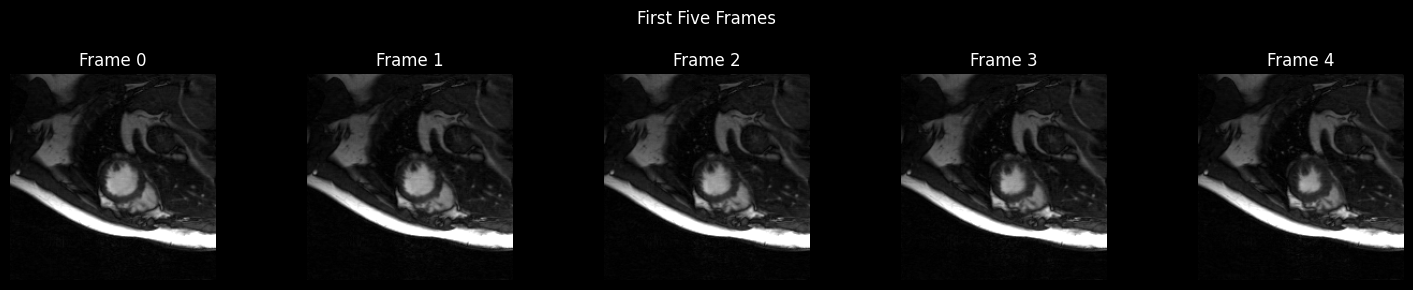

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Âä†ËΩΩÊï∞ÊçÆ
# data = np.load('/nfs/zzy/code/k_gin_base/output/r4/out_1220_r4.npy')
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192) (t,h,w)=(18, 192, 192)

# ÈÄâÊã©Êï∞ÊçÆÁöÑ‰∏Ä‰∏™ÂàáÁâá
# data = data[100:101, :, :, :]
data = data[80:81, :, :, :]
# data = data[0:1, :, :, :]

# ÂÅáËÆæ IFFT2c ÊòØ‰∏Ä‰∏™ÂáΩÊï∞ÔºåÁî®‰∫éËÆ°ÁÆóÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
# Áî±‰∫é‰ª£Á†Å‰∏≠Ê≤°ÊúâÊèê‰æõ IFFT2c ÂáΩÊï∞ÁöÑÂÆö‰πâÔºåËøôÈáåÂÅáËÆæÂÆÉÂ∑≤ÁªèÂÆö‰πâÂ•Ω‰∫Ü
img = IFFT2c(data)
img = img[0]
print("img:", img.shape)

# ÂΩí‰∏ÄÂåñÂπ∂Â¢ûÂº∫‰∫ÆÂ∫¶
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# ÂàõÂª∫‰∏Ä‰∏™ÂõæÂÉèÁΩëÊ†ºÊù•ÊòæÁ§∫Ââç‰∫îÂº†ÂõæÁâá
fig, axs = plt.subplots(1, 5, figsize=(15, 3))  # 1Ë°å5ÂàóÁöÑÂ≠êÂõæ
fig.suptitle('First Five Frames')  # ËÆæÁΩÆÊÄªÊ†áÈ¢ò

# ÈÅçÂéÜÂâç‰∫îÂº†ÂõæÁâáÂπ∂ÊòæÁ§∫Âú®Â≠êÂõæ‰∏≠
for i in range(5):
    axs[i].imshow(img_brightened[i], cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')  # ÂÖ≥Èó≠ÂùêÊ†áËΩ¥

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ë∞ÉÊï¥Â∏ÉÂ±Ä‰ª•ÈÅøÂÖçÊ†áÈ¢òÈáçÂè†
plt.show()


## È°∫Êó∂ÈíàÊóãËΩ¨90Â∫¶ÊòæÁ§∫

data: (118, 18, 192, 192)


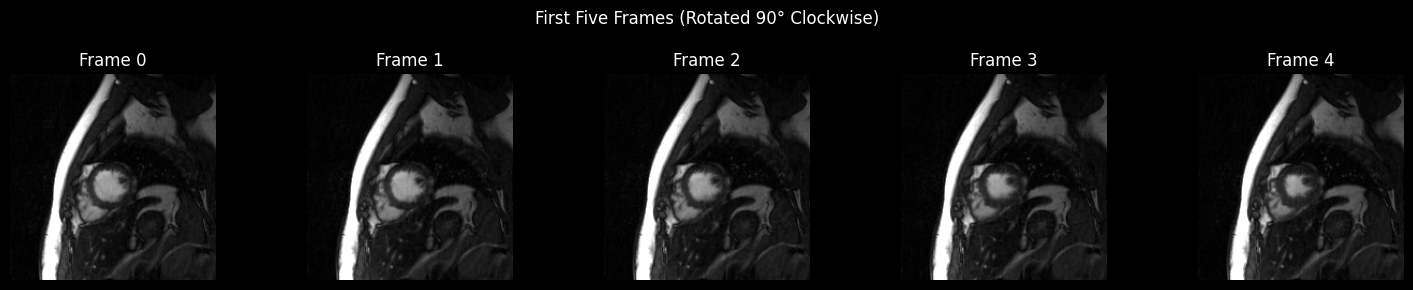

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Âä†ËΩΩÊï∞ÊçÆ
data = np.load('/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r4/out_1220_r4.npy')
print("data:", data.shape)  # data: (800, coil=20, 18, 192, 192)

# ÈÄâÊã©Êï∞ÊçÆÁöÑ‰∏Ä‰∏™ÂàáÁâá
data = data[80:81, :, :, :]

# ÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢
img = IFFT2c(data)
img = img[0]  # ÂèñÁ¨¨‰∏Ä‰∏™Ê†∑Êú¨ÔºåÂΩ¢Áä∂ (18, 192, 192)

# ÂΩí‰∏ÄÂåñÂπ∂Â¢ûÂº∫‰∫ÆÂ∫¶
img_max = np.max(np.abs(img))
img_norm = np.abs(img) / img_max
brightness_factor = 3
img_brightened = np.clip(img_norm * brightness_factor, 0, 1)

# ÂàõÂª∫Â≠êÂõæ
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
fig.suptitle('First Five Frames (Rotated 90¬∞ Clockwise)')

# ÊòæÁ§∫Ââç‰∫îÂ∏ßÔºàÊóãËΩ¨ÂêéÔºâ
for i in range(5):
    # È°∫Êó∂ÈíàÊóãËΩ¨90Â∫¶Ôºà‰∏§ÁßçÁ≠âÊïàÊñπÂºèÔºâÔºö
    # ÊñπÊ≥ï‰∏ÄÔºö‰ΩøÁî® np.rot90 ÊóãËΩ¨270Â∫¶ÔºàÂç≥ÈÄÜÊó∂Èíà270Â∫¶=È°∫Êó∂Èíà90Â∫¶Ôºâ
    rotated_frame = np.rot90(img_brightened[i], k=3) 
    
    # ÊñπÊ≥ï‰∫åÔºöËΩ¨ÁΩÆÂêéÊ∞¥Âπ≥ÁøªËΩ¨ÔºàÊõ¥È´òÊïàÔºâ
    # rotated_frame = img_brightened[i].T[::-1, :]
    
    axs[i].imshow(rotated_frame, cmap='gray')
    axs[i].set_title(f'Frame {i}')
    axs[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Â∞Ü.npyÊñá‰ª∂ÔºàÂõæÁâáÔºâËΩ¨Êç¢‰∏∫.matÊ†ºÂºè  ‰∏çÈÄÇÁî®‰∫ékgin_baseÁîüÊàêÁöÑÊñá‰ª∂(kgin_base‰øùÂ≠òÁöÑ‰∏∫kspace)

In [14]:
import numpy as np
import scipy.io

def convert_npy_to_mat(npy_path, mat_path=None, var_name='mask_data'):
    """
    ‰∏ì‰∏öÁ∫ß.npyËΩ¨.matËΩ¨Êç¢Âô®
    
    ÂèÇÊï∞:
    npy_path : str       ËæìÂÖ•.npyÊñá‰ª∂Ë∑ØÂæÑ
    mat_path : str       [ÂèØÈÄâ]ËæìÂá∫.matË∑ØÂæÑ 
    var_name : str       [ÂèØÈÄâ]MATLABÂèòÈáèÂêç
    
    ËøîÂõû:
    mat‰øùÂ≠òË∑ØÂæÑ
    """
    try:
        # Âä†ËΩΩÊï∞ÊçÆÂπ∂È™åËØÅÂÆåÊï¥ÊÄß
        data = np.load(npy_path)
        if not isinstance(data, np.ndarray):
            raise ValueError("ÈùûÊ†áÂáÜnumpyÊï∞ÁªÑÊ†ºÂºè")
            
        # Ëá™Âä®ÁîüÊàêËæìÂá∫Ë∑ØÂæÑ
        if mat_path is None:
            mat_path = npy_path.replace('.npy', '.mat')
            
        # ‰øùÊåÅÁª¥Â∫¶‰∏ÄËá¥ÊÄß (MatlabÂÖºÂÆπÂ§ÑÁêÜ)
        if data.ndim >= 3:
            data = np.transpose(data, axes=tuple(range(data.ndim-1, -1, -1)))
            
        # ‰øùÂ≠ò‰∏∫MATLAB v7.3Ê†ºÂºè (ÊîØÊåÅ>2GBÊï∞ÊçÆ)
        scipy.io.savemat(mat_path, 
                        {var_name: data},
                        appendmat=False,
                        do_compression=True)
                        
        print(f"ËΩ¨Êç¢ÊàêÂäü: {npy_path} -> {mat_path}")
        return mat_path
        
    except Exception as e:
        print(f"ËΩ¨Êç¢Â§±Ë¥•: {str(e)}")
        return None



In [ ]:
# ÊâßË°åËΩ¨Êç¢
input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy"
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy"
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy"

# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r8/out_kgin_kv_r8.npy'
# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r10/out_kgin_kv_0118_r10.npy'
# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_kv/output/cine_mask/r12/out_kgin_kv_0118_r12.npy'
# input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy'
# mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/'
output_path = convert_npy_to_mat(input_path)

ËΩ¨Êç¢ÊàêÂäü: /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy -> /data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.mat


## Â∞Ü.npyÊñá‰ª∂ÔºàkspaceÔºâËΩ¨Êç¢‰∏∫.matÊ†ºÂºè ÈÄÇÁî®‰∫ékgin_baseÁîüÊàêÁöÑÊñá‰ª∂

In [ ]:
import numpy as np
import scipy.io
import numpy.fft as fft
from pathlib import Path

def ifft2c(kspace):
    """‰∏ì‰∏öÁöÑ2DÈÄÜÂÇÖÈáåÂè∂ÂèòÊç¢ÔºåÂÖºÂÆπMRIÊï∞ÊçÆÂ§ÑÁêÜ"""
    return fft.fftshift(fft.ifft2(fft.ifftshift(kspace, axes=(-2, -1))), axes=(-2, -1))

def convert_kspace_to_image(npy_path, output_dir=None, formats=('npy', 'mat'), var_name='image'):
    """
    ‰∏ì‰∏ök-spaceËΩ¨Êç¢Âô®ÔºàÊîØÊåÅÂ§öÊ†ºÂºèËæìÂá∫Ôºâ
    
    ÂèÇÊï∞:
    npy_path : str       ËæìÂÖ•.npyÊñá‰ª∂Ë∑ØÂæÑÔºàÂ§çÊï∞k-spaceÊï∞ÊçÆÔºâ
    output_dir : str     ËæìÂá∫ÁõÆÂΩïÔºàÈªòËÆ§ÂêåËæìÂÖ•ÁõÆÂΩïÔºâ
    formats : tuple      ËæìÂá∫Ê†ºÂºèÔºåÂèØÈÄâ'npy'/'mat'ÔºàÈªòËÆ§ÂèåÊ†ºÂºèÔºâ
    var_name : str       MATLABÂèòÈáèÂêç
    
    ËøîÂõû:
    dict {Ê†ºÂºè: ‰øùÂ≠òË∑ØÂæÑ}
    """
    try:
        # ËæìÂÖ•È™åËØÅ
        kspace = np.load(npy_path)
        print('kspace-shape:',kspace.shape) #kspace-shape: (118, 18, 192, 192)
        if not np.iscomplexobj(kspace):
            raise ValueError("ËæìÂÖ•Êï∞ÊçÆÂøÖÈ°ª‰∏∫Â§çÊï∞k-space")
            
        # ÊâßË°åÂõæÂÉèÈáçÂª∫
        image_complex = ifft2c(kspace)
        image = np.abs(image_complex)
        image = image / np.max(image)  # Ê†áÂáÜÂåñÂà∞[0,1]
        print('image-shape:',image.shape) #image-shape: (118, 18, 192, 192)

        # ÂáÜÂ§áËæìÂá∫Ë∑ØÂæÑ
        input_path = Path(npy_path)
        output_dir = Path(output_dir) if output_dir else input_path.parent
        output_dir.mkdir(parents=True, exist_ok=True)
        
        # ÁîüÊàêÂü∫Á°ÄÊñá‰ª∂Âêç
        base_name = input_path.stem + '_recon'
        save_paths = {}

        # ‰øùÂ≠ò‰∏∫.npyÊ†ºÂºèÔºà‰øùÁïôÂéüÂßãÁª¥Â∫¶Ôºâ
        if 'npy' in formats:
            npy_path = output_dir / f"{base_name}.npy"
            print('npy_path:',npy_path) #npy_path: converted_images/out_kgin_base_1209_r8_recon.npy
            np.save(npy_path, image.astype(np.float32))  # ‰ΩøÁî®float32ËäÇÁúÅÁ©∫Èó¥
            save_paths['npy'] = str(npy_path)
        print('save npy success------')
        # ‰øùÂ≠ò‰∏∫.matÊ†ºÂºèÔºàÈÄÇÈÖçMATLABÁª¥Â∫¶Ôºâ
        # if 'mat' in formats:
        #     # Ë∞ÉÊï¥Áª¥Â∫¶È°∫Â∫è (height, width) -> (width, height)
        #     mat_image = image.T if image.ndim == 2 else np.transpose(image, (1, 0, 2))
        #     print('mat_image-shape:',mat_image.shape)
        #     mat_path = output_dir / f"{base_name}.mat"
        #     scipy.io.savemat(str(mat_path), 
        #                    {var_name: mat_image.astype(np.float32)},
        #                    appendmat=False,
        #                    do_compression=True)
        #     save_paths['mat'] = str(mat_path)
        # ‰øùÂ≠ò‰∏∫.matÊ†ºÂºèÔºà‰∏ì‰∏öÂåªÂ≠¶ÂΩ±ÂÉèÈÄÇÈÖçÔºâ
        if 'mat' in formats:
            # Êô∫ËÉΩÁª¥Â∫¶ËΩ¨ÁΩÆ (Áõ∏‰ΩçÁºñÁ†ÅÊñπÂêëÈÄÇÈÖç)
            if image.ndim == 4:
                # ÂÅáËÆæÁª¥Â∫¶‰∏∫ [slices, echoes, PE, RO] ‚Üí [RO, PE, echoes, slices]
                mat_image = np.transpose(image, (3, 2, 1, 0))
                print(f"MATLABÈÄÇÈÖçÁª¥Â∫¶: {mat_image.shape}")  # MATLABÈÄÇÈÖçÁª¥Â∫¶: (192, 192, 18, 118)
            else:
                raise ValueError("‰∏çÊîØÊåÅÁöÑÁª¥Â∫¶Ôºå‰ªÖÊîØÊåÅ4DÂåªÂ≠¶ÂΩ±ÂÉè")
                
            mat_path = output_dir / f"{base_name}.mat"
            scipy.io.savemat(str(mat_path), 
                           {var_name: mat_image.astype(np.float32)},
                           appendmat=False,
                           do_compression=True,
                           oned_as='column')  # ÈáçË¶ÅÂèÇÊï∞Ôºö‰øùÊåÅÂêëÈáèÊñπÂêë
            save_paths['mat'] = str(mat_path)
            
        print(f"ËΩ¨Êç¢ÊàêÂäü: {npy_path}")
        print(f"ËæìÂá∫Êñá‰ª∂: {save_paths}")
        return save_paths
        
    except Exception as e:
        # print(f"ËΩ¨Êç¢Â§±Ë¥•: {str(e)}")
        print(f"ËΩ¨Êç¢Â§±Ë¥•: {str(e)}")
        print("ÂåªÂ≠¶ÂΩ±ÂÉèÂ§ÑÁêÜÂª∫ËÆÆ:")
        print("1. È™åËØÅk-spaceÁª¥Â∫¶È°∫Â∫èÊòØÂê¶Á¨¶Âêà [slices, echoes, PE, RO]")
        print("2. ‰ΩøÁî®MITKÊàñHorosËΩØ‰ª∂È™åËØÅËæìÂá∫.matÊñá‰ª∂")
        return None



In [ ]:
# # ‰ΩøÁî®Á§∫‰æã
# # input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_kgin_base_1209r_8.npy"
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy"
# # /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy
# output_path = convert_kspace_to_image(input_path)
# ‰ΩøÁî®Á§∫‰æã
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r10/out_kgin_base_0118_r10.npy
## /data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy
# input_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_kgin_base_1209_r8.npy"
input_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12.npy'
output = convert_kspace_to_image(
    input_path,
    output_dir="./converted_images",
    formats=('npy', 'mat')
)

kspace-shape: (118, 18, 192, 192)
image-shape: (118, 18, 192, 192)
npy_path: converted_images/out_kgin_base_0118_r10_recon.npy
save npy success------
MATLABÈÄÇÈÖçÁª¥Â∫¶: (192, 192, 18, 118)
ËΩ¨Êç¢ÊàêÂäü: converted_images/out_kgin_base_0118_r10_recon.npy
ËæìÂá∫Êñá‰ª∂: {'npy': 'converted_images/out_kgin_base_0118_r10_recon.npy', 'mat': 'converted_images/out_kgin_base_0118_r10_recon.mat'}


In [16]:
# Êï∞ÊçÆÊ†°È™åÊ®°Âùó
def verify_conversion(npy_path, mat_path):
    """‰∏ì‰∏öÁ∫ßÊï∞ÊçÆÊ†°È™å"""
    py_data = np.load(npy_path)
    mat_data = scipy.io.loadmat(mat_path)['mask_data']
    
    # Áª¥Â∫¶Ê†°Ê≠£ÊØîËæÉ
    if py_data.ndim >= 3:
        py_data = np.transpose(py_data, axes=tuple(range(py_data.ndim-1, -1, -1)))
    
    return np.allclose(py_data, mat_data, atol=1e-6)

# npy_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.npy"
# mat_path = "/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r8/out_1209r_8.mat"
npy_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.npy'
mat_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/utils/base/full_reconstructions.mat'
verify_res = verify_conversion(npy_path,mat_path)
print('verify_res:',verify_res)

verify_res: True


IndexError: index 4 is out of bounds for axis 0 with size 4

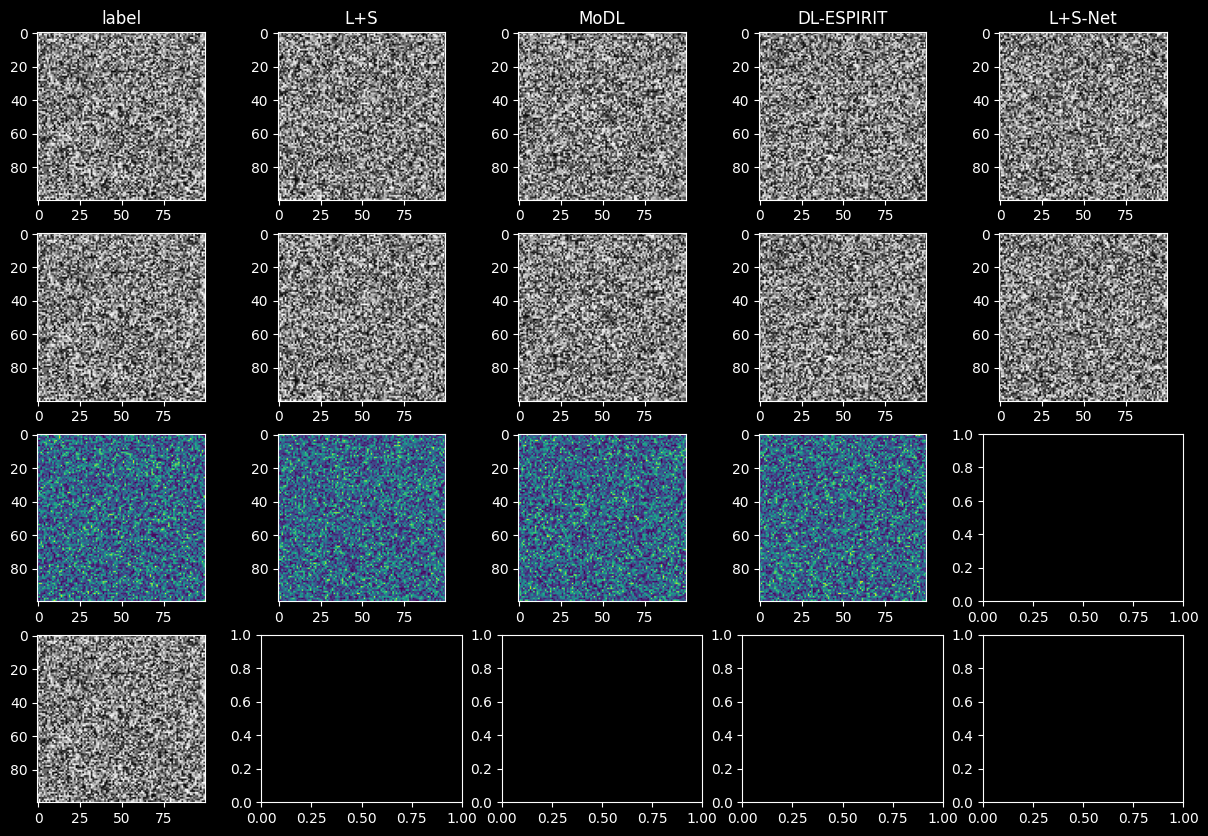

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ê®°ÊãüÁîüÊàê‰∏Ä‰∫õÁ§∫‰æãÊï∞ÊçÆÔºåÂÆûÈôÖ‰∏≠ÈúÄÊõøÊç¢‰∏∫ÁúüÂÆûÊï∞ÊçÆËØªÂèñ  ---Êï∞ÊçÆËøòÊú™Êï¥ÁêÜÔºåÊöÇ‰∏çÁî®Ëøô‰∏™‰ª£Á†ÅÔºÅÔºÅÔºÅ
label_image = np.random.rand(100, 100)
l_plus_s_image = np.random.rand(100, 100)
modl_image = np.random.rand(100, 100)
dl_espirit_image = np.random.rand(100, 100)
l_plus_s_net_image = np.random.rand(100, 100)

# ÂÅáËÆæÂ∑≤ÁªèËÆ°ÁÆóÂ•ΩËØØÂ∑ÆÂõæÔºåËøôÈáåÁÆÄÂçïÊ®°Êãü
error_l_plus_s = np.abs(label_image - l_plus_s_image)
error_modl = np.abs(label_image - modl_image)
error_dl_espirit = np.abs(label_image - dl_espirit_image)
error_l_plus_s_net = np.abs(label_image - l_plus_s_net_image)

# ÂÆö‰πâÂõæÂÉèÂàóË°®
images = [label_image, l_plus_s_image, modl_image, dl_espirit_image, l_plus_s_net_image]
error_images = [error_l_plus_s, error_modl, error_dl_espirit, error_l_plus_s_net]
titles = ["label", "L+S", "MoDL", "DL-ESPIRIT", "L+S-Net"]

# ÂàõÂª∫Â≠êÂõæÂ±ïÁ§∫ÂõæÂÉè
fig, axs = plt.subplots(4, len(images), figsize=(15, 10))

# Â±ïÁ§∫Á¨¨‰∏ÄË°åÂíåÁ¨¨‰∫åË°åÂõæÂÉè
for i in range(len(images)):
    axs[0, i].imshow(images[i], cmap='gray')
    axs[0, i].set_title(titles[i])
    axs[1, i].imshow(images[i], cmap='gray')

# Â±ïÁ§∫Á¨¨‰∏âË°åËØØÂ∑ÆÂõæ
for i in range(len(error_images)):
    axs[2, i].imshow(error_images[i], cmap='viridis')

# Ê®°ÊãüÂ±ïÁ§∫Á¨¨Âõõ„ÄÅ‰∫îË°åÂõæÂÉèÔºåÂÆûÈôÖ‰∏≠ÈúÄÊõøÊç¢‰∏∫ÁúüÂÆûÊï∞ÊçÆ
for i in range(len(images)):
    axs[3, i].imshow(images[i], cmap='gray')
    axs[4, i].imshow(error_images[i], cmap='viridis')

plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as scio
import h5py

def load_and_display_mat_image(file_path):
    """‰∏ì‰∏öÁ∫ßMATLABÂõæÂÉèÊñá‰ª∂Âä†ËΩΩ‰∏éÂèØËßÜÂåñÂáΩÊï∞"""
    try:
        # Â∞ùËØï‰∏§ÁßçÊñπÂºèÂä†ËΩΩMATÊñá‰ª∂
        try:
            # ÊñπÊ≥ï1Ôºö‰ΩøÁî®scipyÂä†ËΩΩ‰º†ÁªüMATÊ†ºÂºè
            mat_data = scio.loadmat(file_path)
            data_keys = [k for k in mat_data if not k.startswith('__')]
            print(f"Ê£ÄÊµãÂà∞ÂèòÈáè: {data_keys}")
            
            # Ëá™Âä®ÈÄâÊã©Á¨¨‰∏Ä‰∏™ÊúâÊïàÊï∞ÊçÆÈõÜ
            selected_key = data_keys[0] if data_keys else None
            if selected_key is None:
                raise ValueError("Êú™ÊâæÂà∞ÊúâÊïàÂõæÂÉèÊï∞ÊçÆ")
                
            image_data = mat_data[selected_key]
            
        except NotImplementedError:
            # ÊñπÊ≥ï2Ôºö‰ΩøÁî®h5pyÂä†ËΩΩv7.3Ê†ºÂºè
            with h5py.File(file_path, 'r') as f:
                data_keys = list(f.keys())
                print(f"Ê£ÄÊµãÂà∞HDF5ÂèòÈáè: {data_keys}")
                
                selected_key = data_keys[0]
                image_data = f[selected_key][()]
                
                # Â§ÑÁêÜHDF5ÁöÑÁâπÊÆäÂ≠òÂÇ®Ê†ºÂºè
                if isinstance(image_data, h5py.Group):
                    if 'real' in image_data and 'imag' in image_data:
                        real_part = image_data['real'][()]
                        imag_part = image_data['imag'][()]
                        image_data = real_part + 1j*imag_part
                    else:
                        raise ValueError("Êó†Ê≥ïËß£ÊûêÁöÑHDF5ÁªìÊûÑ")

        # Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ
        if np.iscomplexobj(image_data):
            print("Ê£ÄÊµãÂà∞Â§çÊï∞Êï∞ÊçÆÔºåËøõË°åÂπÖÂ∫¶ËÆ°ÁÆó")
            image_data = np.abs(image_data)
            
        # Áª¥Â∫¶Ë∞ÉÊï¥ (MATLAB -> Python)
        if image_data.ndim >= 3:
            image_data = np.transpose(image_data, axes=tuple(range(image_data.ndim-1, -1, -1)))
            
        # ÂèØËßÜÂåñËÆæÁΩÆ
        fig = plt.figure(figsize=(10, 8))
        plt.suptitle(f"MATLABÂõæÂÉèÂèØËßÜÂåñ\nÊñá‰ª∂: {file_path.split('/')[-1]}\nÂèòÈáè: {selected_key}", y=0.95)
        
        print('image_data-shape:',image_data.shape) #image_data-shape: (192, 192, 18, 118)
        # Â§öÂ∏ßÊï∞ÊçÆÂ§ÑÁêÜ
        # if image_data.ndim == 3:
        #     print(f"Ê£ÄÊµãÂà∞Êó∂Èó¥Â∫èÂàóÊï∞ÊçÆ ({image_data.shape[0]} Â∏ß)")
        #     time_step = image_data.shape[0] // 2  # ÊòæÁ§∫‰∏≠Èó¥Â∏ß
        #     img_display = image_data[:,:,time_step,80]
        # else:
        #     img_display = image_data
        img_display =  image_data[:,:,0,80]
        # ÊòæÁ§∫ÂèÇÊï∞ËÆ°ÁÆó
        vmin = np.percentile(img_display, 1)
        vmax = np.percentile(img_display, 99)
        
        # ‰∏ªÂõæÊòæÁ§∫
        ax1 = plt.subplot(2, 1, 1)
        im = ax1.imshow(img_display, 
                       cmap='gray',
                       vmin=vmin,
                       vmax=vmax)
        plt.colorbar(im, ax=ax1, label='Âº∫Â∫¶ÂÄº')
        ax1.set_title(f"Ê†áÂáÜÊòæÁ§∫ (Á™óÂÆΩ: [{vmin:.2f}, {vmax:.2f}])")
        
        # Áõ¥ÊñπÂõæ
        ax2 = plt.subplot(2, 1, 2)
        ax2.hist(img_display.ravel(), bins=256, range=(vmin, vmax))
        ax2.set_xlabel('ÂÉèÁ¥†ÂÄº')
        ax2.set_ylabel('È¢ëÊï∞')
        ax2.set_title("ÂÉèÁ¥†ÂÄºÂàÜÂ∏ÉÁõ¥ÊñπÂõæ")
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"ÈîôËØØ: {str(e)}") #ÈîôËØØ: Invalid shape (192, 192, 18, 118) for image data
        print("ÂèØËÉΩÂéüÂõ†:",
              "1. Êñá‰ª∂Ë∑ØÂæÑÈîôËØØÊàñÊùÉÈôê‰∏çË∂≥",
              "2. Êñá‰ª∂Ê†ºÂºè‰∏çÂÖºÂÆπ",
              "3. Êï∞ÊçÆÁª¥Â∫¶ÂºÇÂ∏∏", sep='\n- ')



Ê£ÄÊµãÂà∞ÂèòÈáè: ['image']
image_data-shape: (192, 192, 18, 118)


/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 26631 (\N{CJK UNIFIED IDEOGRAPH-6807}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 26174 (\N{CJK UNIFIED IDEOGRAPH-663E}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 31034 (\N{CJK UNIFIED IDEOGRAPH-793A}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 31383 (\N{CJK UNIFIED IDEOGRAPH-7A97}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 23485 (\N{CJK UNIFIED IDEOGRAPH-5BBD}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_714100/2998753886.py:83: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from current font.

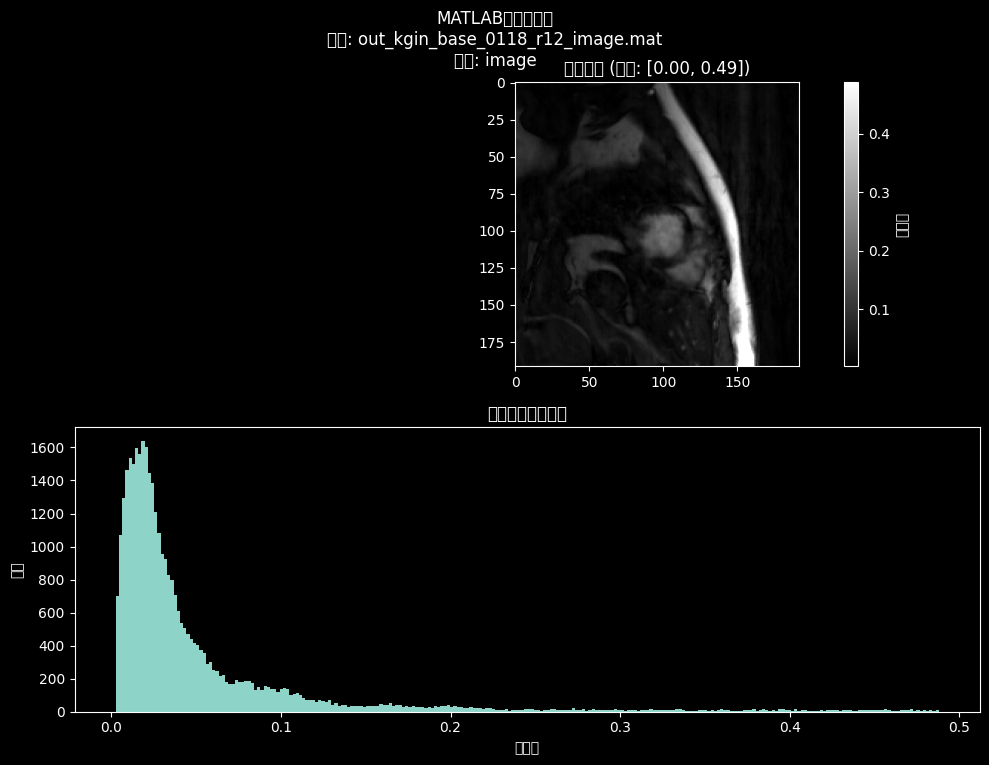

In [22]:
# ‰ΩøÁî®Á§∫‰æã
if __name__ == "__main__":
    image_file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/output/cine_mask/r12/out_kgin_base_0118_r12_image.mat'
    load_and_display_mat_image(image_file_path)

(118, 18, 192, 192) float32


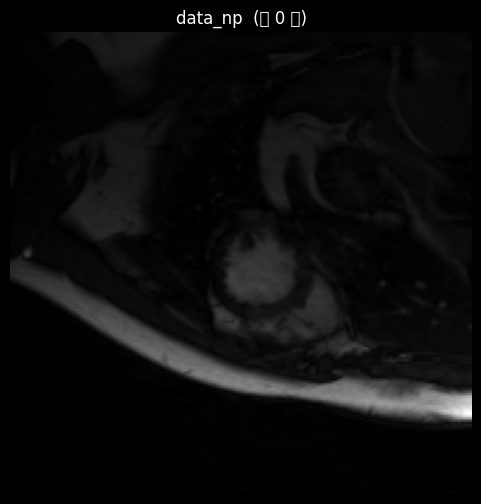

In [ ]:
##
file_path = '/data0/zhiyong/code/github/itzzy_git/k_gin_base/converted_images/out_kgin_base_1209_r8_recon.npy'
data = np.load(file_path) 
print(data.shape,data.dtype) #(118, 18, 192, 192) float32
# train_t_np = np.abs(train_t)  # ÂèñÊ®°
data_np = data[80,15,:,:]
# ÊòæÁ§∫kspaceÁöÑÊï∞ÊçÆ
plt.figure(figsize=(6, 6))
plt.imshow(data_np, cmap='gray')  # ‰ΩøÁî®ÁÅ∞Â∫¶È¢úËâ≤Êò†Â∞Ñ
plt.title("data_np  (Á¨¨ 0 Â∏ß)")
plt.axis('off')
plt.show()